导入相关包

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *

读取数据

In [2]:
raw_data = pd.read_excel('D:/课件/编程基础/homework/final/airlin_runoff.xlsx')

In [3]:
raw_data.head()

,MEMBER_NO,DAYS_FROM_LAST_TO_END,DAYS_FROM_BEGIN_TO_FIRST,FFP_TIER,GENDER,age,FLIGHT_COUNT,FLIGHT_COUNT_QTR_1,FLIGHT_COUNT_QTR_2,FLIGHT_COUNT_QTR_3,...,L1Y_ELi_Add_Points,Points_Sum,L1Y_Points_Sum,Ration_L1Y_Flight_Count,Ration_P1Y_Flight_Count,Ration_P1Y_BPS,Ration_L1Y_BPS,Point_Chg_NotFlight,runoff_flag,FFP_days
0,‘00000001,198,525,4,男,40.0,3,0,0,0,...,0,7035,7035,1.000000,0.000000,0.000000,0.999858,0,1,2923
1,‘00000002,114,57,4,男,52.0,24,1,5,7,...,0,16210,6717,0.458333,0.541667,0.585590,0.414348,0,0,2923
2,‘00000003,84,6,4,女,52.0,9,2,2,0,...,63000,85008,63651,0.333333,0.666667,0.913171,0.086696,5,0,2916
3,‘00000004,30,128,4,男,45.0,12,0,2,2,...,2578,10826,4566,0.333333,0.666667,0.754232,0.245644,13,0,2791
4,‘00000005,95,35,4,男,57.0,3,1,1,0,...,0,2329,264,0.333333,0.666667,0.886266,0.113305,0,0,2245


In [4]:
raw_data.dtypes

MEMBER_NO                    object
DAYS_FROM_LAST_TO_END         int64
DAYS_FROM_BEGIN_TO_FIRST      int64
FFP_TIER                      int64
GENDER                       object
age                         float64
FLIGHT_COUNT                  int64
FLIGHT_COUNT_QTR_1            int64
FLIGHT_COUNT_QTR_2            int64
FLIGHT_COUNT_QTR_3            int64
FLIGHT_COUNT_QTR_4            int64
FLIGHT_COUNT_QTR_5            int64
FLIGHT_COUNT_QTR_6            int64
FLIGHT_COUNT_QTR_7            int64
FLIGHT_COUNT_QTR_8            int64
BASE_POINTS_SUM               int64
BASE_POINTS_SUM_QTR_1         int64
BASE_POINTS_SUM_QTR_2         int64
BASE_POINTS_SUM_QTR_3         int64
BASE_POINTS_SUM_QTR_4         int64
BASE_POINTS_SUM_QTR_5         int64
BASE_POINTS_SUM_QTR_6         int64
BASE_POINTS_SUM_QTR_7         int64
BASE_POINTS_SUM_QTR_8         int64
ELITE_POINTS_SUM_YR_1         int64
ELITE_POINTS_SUM_YR_2         int64
EXPENSE_SUM_YR_1            float64
EXPENSE_SUM_YR_2            

In [5]:
print(raw_data.columns.size)#列数 
print(raw_data.iloc[:,0].size)#行数 

56
62988


特殊值处理

In [6]:
clean_data = raw_data.copy()
clean_data_cols = []
clean_data_rows = []

1.对MEMBER_NO格式做修改，原来的格式为’00000001，转化为00000001

In [7]:
clean_data['MEMBER_NO'] = raw_data['MEMBER_NO'].apply(lambda x: x.split("‘")[1])

2.将性别变量由字符型转化为数值型

In [8]:
sex_mapping = {"男": 0, "女": 1}
clean_data['GENDER'] = clean_data['GENDER'].map(sex_mapping)

clean_data_cols.append(clean_data.columns.size)
clean_data_rows.append(clean_data.iloc[:,0].size)

3.丢弃最大乘机间隔为0的客户记录

In [9]:
clean_data = clean_data[~clean_data['MAX_FLIGHT_INTERVAL'].eq(0)] 

clean_data_cols.append(clean_data.columns.size)
clean_data_rows.append(clean_data.iloc[:,0].size)

4.剔除第一年票价（ EXPENSE\_SUM\_YR\_1）为空，第二年票价（EXPENSE\_SUM\_YR\_2）为0的客户记录

In [10]:
clean_data = clean_data[~(clean_data['EXPENSE_SUM_YR_1'].isnull() & clean_data['EXPENSE_SUM_YR_2'].eq(0))]

clean_data_cols.append(clean_data.columns.size)
clean_data_rows.append(clean_data.iloc[:,0].size)

5.删除年龄（age）大于 70 的观测

In [11]:
clean_data = clean_data[~(clean_data['age']>70)]

clean_data_cols.append(clean_data.columns.size)
clean_data_rows.append(clean_data.iloc[:,0].size)

6.对于分各季度与总值的变量，统一只保留总值（飞行次数1-8季度 第1，2年平均)

In [12]:
cols = []
for i in range(1, 9):
    cols.append('FLIGHT_COUNT_QTR_%s' % i)
    cols.append('BASE_POINTS_SUM_QTR_%s' % i)
cols = cols + ['AVG_FLIGHT_COUNT','AVG_BASE_POINTS_SUM'] + ['P1Y_BASE_POINTS_SUM','L1Y_BASE_POINTS_SUM'] + ['P1Y_Flight_Count','L1Y_Flight_Count']
clean_data = clean_data.drop(cols,axis=1)

clean_data_cols.append(clean_data.columns.size)
clean_data_rows.append(clean_data.iloc[:,0].size)

7.冗余的变量
精英积分+总加权飞行公里数+乘机次数比例+积分比例

In [13]:
cols = ['ELITE_POINTS_SUM_YR_1','ELITE_POINTS_SUM_YR_2','ELITE_POINTS_SUM','WEIGHTED_SEG_KM','Ration_L1Y_Flight_Count','Ration_P1Y_Flight_Count','Ration_P1Y_BPS','Ration_L1Y_BPS']
clean_data = clean_data.drop(cols,axis=1)

clean_data_cols.append(clean_data.columns.size)
clean_data_rows.append(clean_data.iloc[:,0].size)

8.其他积分处理

In [14]:
clean_data['ADD_POINTS_SUM_YR'] = clean_data['ADD_POINTS_SUM_YR_1'] + clean_data['ADD_POINTS_SUM_YR_2']
clean_data['ADD_POINTS_SUM_YR'][clean_data['ADD_POINTS_SUM_YR']>0] = 1
clean_data = clean_data.drop(['ADD_POINTS_SUM_YR_1','ADD_POINTS_SUM_YR_2'],axis=1)

clean_data_cols.append(clean_data.columns.size)
clean_data_rows.append(clean_data.iloc[:,0].size)

<ipython-input-14-ac3e0e3582de>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9.其他处理

In [15]:
clean_data = clean_data.drop(['ADD_POINTS_SUM','AVG_FLIGHT_INTERVAL','MAX_FLIGHT_INTERVAL','DAYS_FROM_LAST_TO_END','Eli_Add_Point_Sum','L1Y_ELi_Add_Points','Points_Sum','L1Y_Points_Sum','Point_Chg_NotFlight','MILEAGE_IN_COUNT'],axis=1)

clean_data_cols.append(clean_data.columns.size)
clean_data_rows.append(clean_data.iloc[:,0].size)

## 缺失值处理

1.统计缺失值

In [17]:
na1 = clean_data.isnull().sum()
print(na1)

MEMBER_NO                     0
DAYS_FROM_BEGIN_TO_FIRST      0
FFP_TIER                      0
GENDER                        3
age                         413
FLIGHT_COUNT                  0
BASE_POINTS_SUM               0
EXPENSE_SUM_YR_1              0
EXPENSE_SUM_YR_2            134
SEG_KM_SUM                    0
EXCHANGE_COUNT                0
avg_discount                  0
runoff_flag                   0
FFP_days                      0
ADD_POINTS_SUM_YR             0
dtype: int64


2.将性别缺失值的样本删除并将性别转化为整数型

In [18]:
clean_data = clean_data[~clean_data['GENDER'].isnull()]
clean_data['GENDER'] = clean_data.GENDER.astype(int)

3.对EXPENSE_SUM_YR_2变量缺失值用0填充

In [19]:
clean_data['EXPENSE_SUM_YR_2'] = clean_data['EXPENSE_SUM_YR_2'].fillna(0)

4.使用热卡插补法填充age

In [20]:
from sklearn.impute import KNNImputer

hot_deck_imputer = KNNImputer(n_neighbors=2, weights="uniform")  
hot_clean_data = pd.DataFrame(hot_deck_imputer.fit_transform(clean_data),index = clean_data.index)

clean_data['age'][clean_data['age'].isnull()] = hot_clean_data[4][clean_data['age'].isnull()]
na2 = clean_data.isnull().sum()
pd.concat([na1, na2], axis=1)
clean_data_cols.append(clean_data.columns.size)
clean_data_rows.append(clean_data.iloc[:,0].size)

<ipython-input-20-a1b58bb938a2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


数据清洗过程及结果

In [21]:
pd.DataFrame({'cols':clean_data_cols,'rows':clean_data_rows})

,cols,rows
0,56,62988
1,56,62567
2,56,62037
3,56,61476
4,34,61476
5,26,61476
6,25,61476
7,15,61476
8,15,61473


In [22]:
clean_data.head()

,MEMBER_NO,DAYS_FROM_BEGIN_TO_FIRST,FFP_TIER,GENDER,age,FLIGHT_COUNT,BASE_POINTS_SUM,EXPENSE_SUM_YR_1,EXPENSE_SUM_YR_2,SEG_KM_SUM,EXCHANGE_COUNT,avg_discount,runoff_flag,FFP_days,ADD_POINTS_SUM_YR
0,00000001,525,4,0,40.0,3,7035,0.0,7200.0,18770,0,0.658303,1,2923,0
1,00000002,57,4,0,52.0,24,16210,7981.0,6860.0,35087,0,0.615947,0,2923,0
2,00000003,6,4,1,52.0,9,7508,5793.0,2288.0,20660,2,0.522271,0,2916,1
3,00000004,128,4,0,45.0,12,8092,6970.0,3226.0,23071,0,0.511084,0,2791,1
4,00000005,35,4,0,57.0,3,2329,2480.0,380.0,2897,0,0.954166,0,2245,0


In [23]:
clean_data.dtypes

MEMBER_NO                    object
DAYS_FROM_BEGIN_TO_FIRST      int64
FFP_TIER                      int64
GENDER                        int32
age                         float64
FLIGHT_COUNT                  int64
BASE_POINTS_SUM               int64
EXPENSE_SUM_YR_1            float64
EXPENSE_SUM_YR_2            float64
SEG_KM_SUM                    int64
EXCHANGE_COUNT                int64
avg_discount                float64
runoff_flag                   int64
FFP_days                      int64
ADD_POINTS_SUM_YR             int64
dtype: object

## 描述性统计分析

定义一个类用于数据的描述性统计分析

In [24]:
class data_analysis():
    
    def __init__(self,dataframe):
        self.cols = list(dataframe.columns.values)
        self.dataframe = dataframe
    
#     此函数可以计算分类变量各类所占百分比，col可以是单个变量也可以是多个变量计算复合百分比
    def class_percentage(self,col):
#         如果变量名不在dataframe中则抛出错误
        if col not in self.cols:
            raise TypeError('{}不在数据集中'.format(col))
        col_data = self.dataframe.groupby(col).count()['MEMBER_NO']
        per_data = col_data.div(col_data.sum(), axis=0)
        return per_data  

#     此函数可以获取两列类别变量的频数分布表
    def frequency_table(self,col):
#        如果任意变量名不在dataframe中则抛出错误 
        if not set(col).issubset(set(self.cols)):
            raise TypeError('请输入正确的变量！')
#        如果输入的变量超过2个则抛出错误
        if len(col)!=2:
            raise TypeError('只能输入两个变量！')
        fre_melt_data = pd.DataFrame(self.dataframe[col].value_counts()).reset_index()
        fre_melt_data.rename(columns = {0: "frequency"},inplace=True)
        frequency_data = fre_melt_data.pivot(index=[col[0]],columns=[col[1]])
        frequency_data['total'] =  frequency_data.iloc[:,:].apply(np.sum, axis=1)
        return frequency_data

    
#     此函数可以输出类别变量频数所占百分比表
    def frequency_percentage_table(self,col,axis):
#         axis=1表示按照行求百分比，axis=0表示按照列求百分比
        freq_tabel = self.frequency_table(col).drop(['total'],axis=1)
        if axis == 1:
            per_table = freq_tabel.div(freq_tabel.sum(axis=1), axis=0)
        else:
            per_table = freq_tabel.div(freq_tabel.sum(axis=0), axis=1)
        return per_table

#     此函数可以输出一个dict,其中包括分类变量每个类对应的'runoff_flag'所有观测
    def group_out(self,col):
        groupednumbers = {}
        for grp in self.dataframe[col].unique(): 
            groupednumbers[grp] = self.dataframe['runoff_flag'][self.dataframe[col]==grp].values
        return groupednumbers
    
 
    def draw_pie(self,col):
        data = self.frequency_table(col = col + ['runoff_flag']).drop(['total'],axis=1)
        pic = plt.figure(figsize=(8,8),dpi=80)
        class_num = data.iloc[:,0].size
        labels = list(data.index.values)
        for i in range(class_num):
            a = pic.add_subplot(1,class_num,i+1)
            b = data.iloc[i,:].index.values
            plt.pie(data.iloc[i,:],labels=['留存率','流失率'],autopct='%.2f%%',shadow=True,explode=[0.02,0.02])
            plt.title('{}= %s'.format(col[0]) %labels[i],fontsize=12)
    
    def draw_bar(self,col):
        data =  pd.DataFrame(self.dataframe[col+['runoff_flag']].value_counts()).reset_index()
        pd.Categorical(data[col[0]], categories=data[col[0]].unique())
        data['runoff_flag'] = pd.Categorical(data['runoff_flag'], categories=data['runoff_flag'].unique())
        data.rename(columns = {0: "frequency"},inplace=True)
        g = (
            ggplot(data, aes(x=col[0], y='frequency', fill='runoff_flag'))
            + geom_col(stat='identity', position='dodge')
            + theme_classic()
            + theme(text = element_text(family = 'SimHei'))  
        ) 
        return g

连续变量离散化

In [25]:
des_data = clean_data.copy()
min_discount = min(des_data['avg_discount'])
max_discount = max(des_data['avg_discount'])
bins = [min_discount-0.1, 0.6, 0.8, max_discount+0.1]
des_data['avg_discount'] = pd.cut(des_data['avg_discount'], bins, right=True,labels=['低','中','高']) 

min_flight_count = min(des_data['FLIGHT_COUNT'])
max_flight_count = max(des_data['FLIGHT_COUNT'])
bins = [min_flight_count-0.1, 3, 7,15, max_flight_count+0.1]
des_data['FLIGHT_COUNT'] = pd.cut(des_data['FLIGHT_COUNT'], bins, right=True,labels=['少','较少','较多','多']) 

min_seg_sum = min(des_data['SEG_KM_SUM'])
max_seg_sum = max(des_data['SEG_KM_SUM'])
bins = [min_seg_sum-0.1, 5000, 10000,20000, max_seg_sum+0.1]
des_data['SEG_KM_SUM'] = pd.cut(des_data['SEG_KM_SUM'], bins, right=True,labels=['低','中','中长','长'])

min_points_sum = min(des_data['BASE_POINTS_SUM'])
max_points_sum = max(des_data['BASE_POINTS_SUM'])
bins = [min_points_sum-0.1, 2000, 6000,max_points_sum+0.1]
des_data['BASE_POINTS_SUM'] = pd.cut(des_data['BASE_POINTS_SUM'], bins, right=True,labels=['低','中','高'])

In [26]:
des_data_class = data_analysis(des_data)

异常抛出试验

In [27]:
print(des_data_class.class_percentage(col = 'runff_flag'))

TypeError: runff_flag不在数据集中

In [28]:
des_data_class.frequency_table(col = ['FF_TIER','runoff_flag'])

TypeError: 请输入正确的变量！

In [29]:
des_data_class.frequency_table(col = ['runoff_flag'])

TypeError: 只能输入两个变量！

描述性分析

In [30]:
plt.style.use('seaborn-white')

1.基本描述

流失用户占比

In [31]:
print(des_data_class.class_percentage(col = 'runoff_flag'))

runoff_flag
0    0.621818
1    0.378182
Name: MEMBER_NO, dtype: float64


性别比例

In [32]:
print(des_data_class.class_percentage(col = 'GENDER'))

GENDER
0    0.765263
1    0.234737
Name: MEMBER_NO, dtype: float64


会员等级比例

In [33]:
print(des_data_class.class_percentage(col = 'FFP_TIER'))

FFP_TIER
4    0.920420
5    0.055146
6    0.024433
Name: MEMBER_NO, dtype: float64


会员等级与流失标志频数列联表

In [34]:
des_data_class.frequency_table(col = ['FFP_TIER','runoff_flag'])

frequency         total
runoff_flag         0      1       
FFP_TIER                           
4               33666  22915  56581
5                3220    170   3390
6                1339    163   1502

会员等级与流失标志百分比列联表

In [35]:
des_data_class.frequency_percentage_table(col = ['FFP_TIER','runoff_flag'],axis=1)

frequency          
runoff_flag         0         1
FFP_TIER                       
4            0.595005  0.404995
5            0.949853  0.050147
6            0.891478  0.108522

性别与流失标志频数列联表

In [36]:
des_data_class.frequency_table(col = ['GENDER','runoff_flag'])

frequency         total
runoff_flag         0      1       
GENDER                             
0               30086  16957  47043
1                8139   6291  14430

## 列联分析

### 客户特征：会员卡等级与流失指标的列联分析

非参数检验

In [37]:
import scipy.stats as stats
groupednumbers = des_data_class.group_out('FFP_TIER')
stats.kruskal(groupednumbers[4],groupednumbers[5],groupednumbers[6])

KruskalResult(statistic=2188.613592848183, pvalue=0.0)

饼图

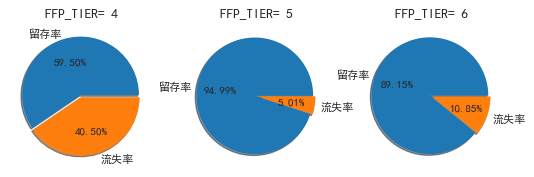

In [38]:
plt.rcParams['font.sans-serif']=['SimHei']
des_data_class.draw_pie(['FFP_TIER'])

### 会员特征：平均折扣率与流失指标列联分析 

In [39]:
des_data_class.frequency_table(col = ['avg_discount','runoff_flag'])

frequency         total
runoff_flag          0      1       
avg_discount                        
低                 7647   6190  13837
中                20850  10350  31200
高                 9728   6708  16436

条形图

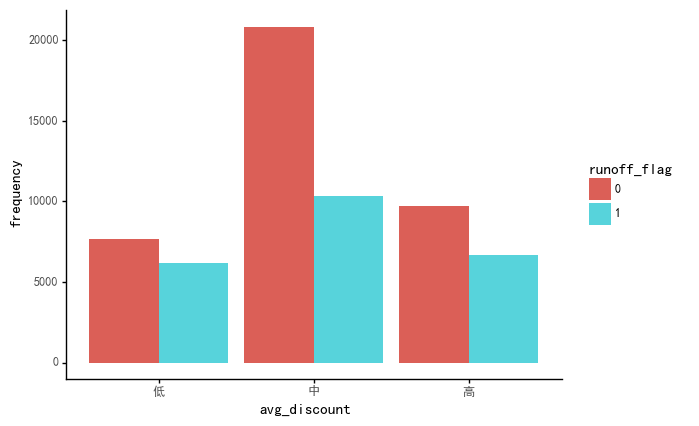

<ggplot: (181231015367)>

In [40]:
des_data_class.draw_bar(['avg_discount'])

Kruskal-Wallis 检验

In [41]:
groupednumbers = des_data_class.group_out('avg_discount')
stats.kruskal(groupednumbers['低'],groupednumbers['中'],groupednumbers['高'])

KruskalResult(statistic=630.4618129323329, pvalue=1.2501346606323494e-137)

飞行特征：飞行次数与流失指标的列联检验

In [42]:
des_data_class.frequency_table(col = ['FLIGHT_COUNT','runoff_flag'])

frequency         total
runoff_flag          0      1       
FLIGHT_COUNT                        
少                 4818  10972  15790
较少                9491   6843  16334
较多               11121   3658  14779
多                12795   1775  14570

条形图

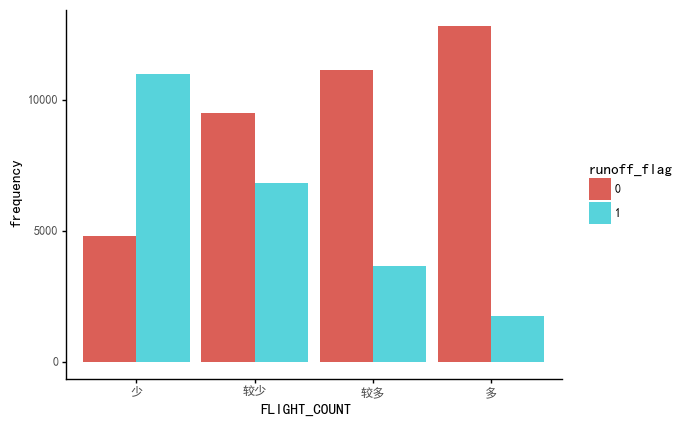

<ggplot: (181231060980)>

In [43]:
des_data_class.draw_bar(['FLIGHT_COUNT'])

Kruskal-Wallis 检验

In [44]:
groupednumbers = des_data_class.group_out('FLIGHT_COUNT')
stats.kruskal(groupednumbers['少'],groupednumbers['较少'],groupednumbers['较多'],groupednumbers['多'])

KruskalResult(statistic=11994.16355434787, pvalue=0.0)

### 积分特征：总基本积分与流失指标的列联分析

In [45]:
des_data_class.frequency_table(col = ['BASE_POINTS_SUM','runoff_flag'])

frequency        total
runoff_flag             0     1       
BASE_POINTS_SUM                       
低                    3778  7507  11285
中                   10686  9434  20120
高                   23761  6307  30068

条形图

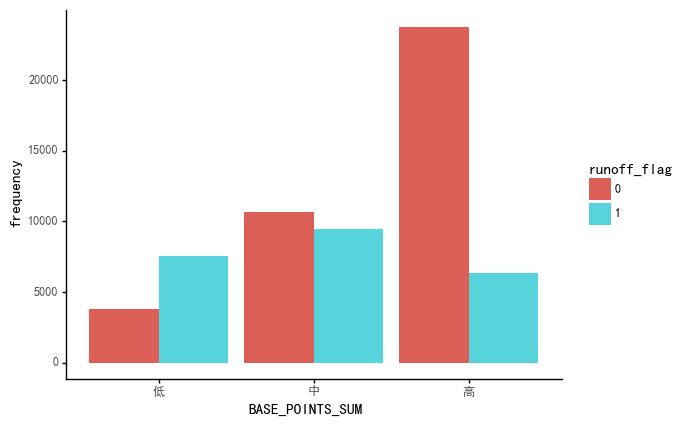

<ggplot: (181231218673)>

In [46]:
des_data_class.draw_bar(['BASE_POINTS_SUM'])

Kruskal-Wallis 检验

In [47]:
groupednumbers = des_data_class.group_out('BASE_POINTS_SUM')
stats.kruskal(groupednumbers['低'],groupednumbers['中'],groupednumbers['高'])

KruskalResult(statistic=8284.589307497557, pvalue=0.0)

用户画像

In [48]:
(clean_data.groupby('runoff_flag').mean()).T

runoff_flag,0,1
DAYS_FROM_BEGIN_TO_FIRST,103.034009,148.287681
FFP_TIER,4.154297,4.021335
GENDER,0.212923,0.270604
age,42.592845,41.584351
FLIGHT_COUNT,15.553015,6.189995
BASE_POINTS_SUM,14347.669300,5685.744408
EXPENSE_SUM_YR_1,6377.364604,3750.352430
EXPENSE_SUM_YR_2,7957.624147,1946.543273
SEG_KM_SUM,22210.616089,9352.946232
EXCHANGE_COUNT,0.446566,0.124312


建立模型

In [49]:
# 数据处理
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# 模型
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

# 模型评价
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
# ROC和PR图
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve

1.提取特征

In [50]:
x = clean_data.drop(['runoff_flag'],axis=1)
y = clean_data['runoff_flag']

设置训练集跟测试集

In [51]:
np.random.seed(2021)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=450)

查看训练集和测试集响应变量分类情况

In [52]:
print('训练集中，因变量 cls 分类情况：')
print(y_train.agg(['value_counts']).T)
print('='*55 + '\n')
print('测试集中，因变量 cls 分类情况：')
print(y_test.agg(['value_counts']).T)

训练集中，因变量 cls 分类情况：
                  0      1
value_counts  30600  18578

测试集中，因变量 cls 分类情况：
                 0     1
value_counts  7625  4670


logistic回归

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      7625
           1       0.70      0.67      0.69      4670

    accuracy                           0.77     12295
   macro avg       0.75      0.75      0.75     12295
weighted avg       0.76      0.77      0.77     12295

              precision    recall  f1-score   support

           0       0.86      0.66      0.75      7625
           1       0.60      0.82      0.69      4670

    accuracy                           0.72     12295
   macro avg       0.73      0.74      0.72     12295
weighted avg       0.76      0.72      0.72     12295

              precision    recall  f1-score   support

           0       0.94      0.23      0.36      7625
           1       0.44      0.98      0.60      4670

    accuracy                           0.51     12295
   macro avg       0.69      0.60      0.48     12295
weighted avg       0.75      0.51      0.46     12295



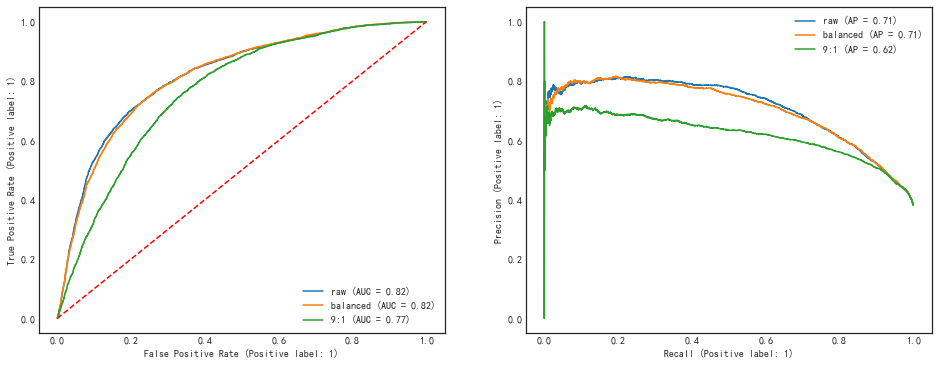

In [53]:
fig, ax = plt.subplots(1,2,figsize=(16, 6))
model_logistic_r = LR(penalty="l2",solver="liblinear",C=0.64 ,max_iter=1000)
model_logistic_r.fit(x_train,y_train)
model_logistic_r_roc = plot_roc_curve(model_logistic_r, x_test, y_test, ax=ax[0],name='raw')
y_pred_r = model_logistic_r.predict(x_test)
print(classification_report(y_test,y_pred_r))
model_logistic_r_pr = plot_precision_recall_curve(model_logistic_r, x_test, y_test, ax=ax[1],name = 'raw')

model_logistic_b = LR(penalty="l2",solver="liblinear",C=0.64 ,max_iter=1000,class_weight ='balanced' )
model_logistic_b.fit(x_train,y_train)
model_logistic_b_roc = plot_roc_curve(model_logistic_b, x_test, y_test, ax=ax[0],name='balanced')
y_pred_b = model_logistic_b.predict(x_test)
print(classification_report(y_test,y_pred_b))
model_logistic_b_pr = plot_precision_recall_curve(model_logistic_b, x_test, y_test, ax=ax[1],name = 'balanced')


model_logistic = LR(penalty="l2",solver="liblinear",C=0.64 ,max_iter=1000,class_weight ={0:0.1, 1:0.9} )
model_logistic.fit(x_train,y_train)
model_logistic_roc = plot_roc_curve(model_logistic, x_test, y_test, ax=ax[0],name='9:1')
y_pred = model_logistic.predict(x_test)
print(classification_report(y_test,y_pred))
model_logistic_pr = plot_precision_recall_curve(model_logistic, x_test, y_test, ax=ax[1],name = '9:1')


ax[0].plot([0, 1], [0, 1], linestyle='--', color='r')
plt.legend(loc='upper right')

参数调优

In [54]:
parameters = {'n_estimators':[1,2,4,6], 'max_depth':[2,4,6], 'min_samples_leaf':[1,4,6]}
new_model = RandomForestClassifier(random_state=1)
grid_search = GridSearchCV(new_model, parameters, cv=6, scoring='accuracy')
grid_search.fit(x_train, y_train)
grid_search.best_params_
print('最优模型参数： ' + str(grid_search.best_params_))

最优模型参数： {'max_depth': 4, 'min_samples_leaf': 6, 'n_estimators': 2}


不同权重决策树 

              precision    recall  f1-score   support

           0       0.78      0.95      0.86      7625
           1       0.87      0.57      0.69      4670

    accuracy                           0.81     12295
   macro avg       0.83      0.76      0.78     12295
weighted avg       0.82      0.81      0.80     12295

              precision    recall  f1-score   support

           0       0.79      0.91      0.84      7625
           1       0.80      0.61      0.69      4670

    accuracy                           0.79     12295
   macro avg       0.79      0.76      0.77     12295
weighted avg       0.79      0.79      0.79     12295

              precision    recall  f1-score   support

           0       0.96      0.09      0.16      7625
           1       0.40      0.99      0.57      4670

    accuracy                           0.43     12295
   macro avg       0.68      0.54      0.37     12295
weighted avg       0.75      0.43      0.32     12295



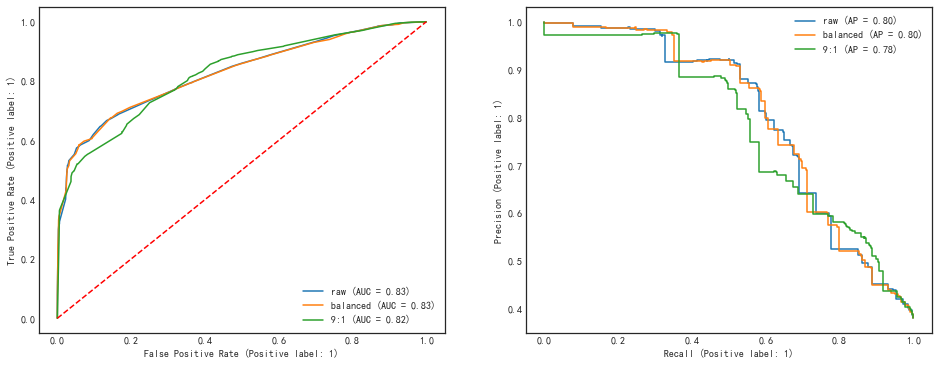

In [55]:
fig, ax = plt.subplots(1,2,figsize=(16, 6))
model_RF_r = RandomForestClassifier(max_depth=4, n_estimators=2, min_samples_leaf=6, random_state=1)
model_RF_r.fit(x_train,y_train)
model_RF_r_roc = plot_roc_curve(model_RF_r, x_test, y_test, ax=ax[0],name='raw')
y_pred_r = model_RF_r.predict(x_test)
print(classification_report(y_test,y_pred_r))
model_RF_r_pr = plot_precision_recall_curve(model_RF_r, x_test, y_test, ax=ax[1],name = 'raw')

model_RF_b = RandomForestClassifier(max_depth=4, n_estimators=2, min_samples_leaf=6, random_state=1,class_weight = 'balanced')
model_RF_b.fit(x_train,y_train)
model_RF_b_roc = plot_roc_curve(model_RF_b, x_test, y_test, ax=ax[0],name='balanced')
y_pred_b = model_RF_b.predict(x_test)
print(classification_report(y_test,y_pred_b))
model_RF_b_pr = plot_precision_recall_curve(model_RF_b, x_test, y_test, ax=ax[1],name = 'balanced')


model_RF = RandomForestClassifier(max_depth=4, n_estimators=2, min_samples_leaf=6, random_state=1,class_weight = {0:0.1, 1:0.9})
model_RF.fit(x_train,y_train)
model_RF_roc = plot_roc_curve(model_RF, x_test, y_test, ax=ax[0],name='9:1')
y_pred = model_RF.predict(x_test)
print(classification_report(y_test,y_pred))
model_RF_pr = plot_precision_recall_curve(model_RF, x_test, y_test, ax=ax[1],name = '9:1')


ax[0].plot([0, 1], [0, 1], linestyle='--', color='r')
plt.legend(loc='upper right')

In [56]:
features = x.columns
importances = model_RF_r.feature_importances_
b = pd.DataFrame()
b['特征'] = features
b['特征重要性'] = importances
b = b.sort_values('特征重要性', ascending=False)
print(b)

                          特征     特征重要性
8           EXPENSE_SUM_YR_2  0.570701
5               FLIGHT_COUNT  0.274474
1   DAYS_FROM_BEGIN_TO_FIRST  0.065438
10            EXCHANGE_COUNT  0.050437
6            BASE_POINTS_SUM  0.014754
12                  FFP_days  0.010239
2                   FFP_TIER  0.003919
7           EXPENSE_SUM_YR_1  0.003868
13         ADD_POINTS_SUM_YR  0.002666
4                        age  0.001543
11              avg_discount  0.001506
9                 SEG_KM_SUM  0.000305
0                  MEMBER_NO  0.000094
3                     GENDER  0.000056


查看各个包的版本

In [57]:
import plotnine
print("plotnine version: {}".format(plotnine.__version__))

import pandas as pd
print("pandas version: {}".format(pd.__version__))

import matplotlib
print("matplotlib version: {}".format(matplotlib.__version__))

import numpy as np
print("NumPy version: {}".format(np.__version__))

import scipy as sp
print("SciPy version: {}".format(sp.__version__))

import sklearn
print("scikit-learn version: {}".format(sklearn.__version__))

plotnine version: 0.8.0
pandas version: 1.2.4
matplotlib version: 3.3.4
NumPy version: 1.20.1
SciPy version: 1.6.2
scikit-learn version: 0.24.1


plotnine version: 0.8.0  
pandas version: 1.2.4  
matplotlib version: 3.3.4  
NumPy version: 1.20.1   
SciPy version: 1.6.2  
scikit-learn version: 0.24.1